In [1]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# input 
# raw pose data from 9/12 videos 
yolo_raw_data_path = r'C:\Users\mmccu\Box\Brainwalk\Home Video Walking\Megan Project\bw_data_and_code\gait\gait_hc_outputs\MM_HC_test_distance\000_raw_pose_data\2024_09_12_02_41_PWS_1_gait_vertical_left_yolo.csv'
yolo_raw_df = pd.read_csv(yolo_raw_data_path, index_col = 0)
# frames per second 
fps_path = r'C:\Users\mmccu\Box\Brainwalk\Home Video Walking\Megan Project\bw_data_and_code\gait\gait_hc_outputs\MM_HC_test_distance\000_raw_pose_data\2024_09_12_02_41_PWS_1_gait_vertical_left_fps.csv'
fps_df = pd.read_csv(fps_path, index_col = 0)

# ground truth data with frames when person was at each end of mat 
ground_truth_path = r'C:\Users\mmccu\Box\Brainwalk\Home Video Walking\Megan Project\bw_data_and_code\gait\gait_hc_videos\MM_HC_test_distance\frames_at_end_of_mat_manual.xlsx'
ground_truth_df = pd.read_excel(ground_truth_path, sheet_name = 'Sheet1', engine='openpyxl')


In [3]:
# distance of tall camera to front edge of mat (meters)
#9ft -> meters 
cam_1_dist = 9 * (0.305)

# distance of short camera to back edge of mat (meters)
cam_2_dist = 6 * (0.305)

# mat length = 17 ft 
mat_length = 17 * (0.305)

In [4]:
# stenum paper formula 
# delta_d: depth change of the torso relative to the initial starting depth 
# s_ratio = ratio of current pixel torso size relative to the pixel size or torso at reference depth (current pixel height / reference pixel height)
# d_ref = initial reference depth of person relative to the frontal camera position

# s_ratio = s_i (current pixel height) / s_ref (pixel height at ref distance) 
# delta_d = (d_ref/s_ratio) - d_ref 

In [5]:
# metric options for s_ratio 
    # options - height (neck to shoulder), width (r vs l shoulder), torso area (square root of product of torso ehgith and shoulder width)

# starting with torso height - with turn, width may be inaccurate 
# frame ref = reference distance frame 
# frame_i = current frame 
def calculate_torso_height_ratio_btwn_frames(yolo_df, frame_ref, frame_i):
    yolo_r_shoulder = yolo_raw_df.loc[yolo_raw_df['label'] == 'right_shoulder']
    yolo_r_shoulder.index = yolo_r_shoulder['frame']
    yolo_l_shoulder = yolo_raw_df.loc[yolo_raw_df['label'] == 'left_shoulder']
    yolo_l_shoulder.index = yolo_l_shoulder['frame']
    yolo_r_hip = yolo_raw_df.loc[yolo_raw_df['label'] == 'right_hip']
    yolo_r_hip.index = yolo_r_hip['frame']
    yolo_l_hip = yolo_raw_df.loc[yolo_raw_df['label'] == 'left_hip']
    yolo_l_hip.index = yolo_l_hip['frame']

    # plot both heights 
    fig1, (ax1, ax2) = plt.subplots(2, figsize=(12, 6))
    ax1.plot(-yolo_r_shoulder['Y'], label = 'r_shoulder -Y')
    ax1.plot(-yolo_r_hip['Y'], label = 'r_hip -Y')
    ax1.vlines(x = frame_ref, ymin = min(-yolo_r_hip['Y']), ymax = max(-yolo_r_shoulder['Y']), color = 'black', label = 'frame_ref')
    ax1.vlines(x = frame_i, ymin = min(-yolo_r_hip['Y']), ymax = max(-yolo_r_shoulder['Y']), color = 'red', label = 'frame_i')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax2.plot(-yolo_l_shoulder['Y'], label = 'l_shoulder -Y')
    ax2.plot(-yolo_l_hip['Y'], label = 'l_hip -Y')
    ax2.vlines(x = frame_ref, ymin = min(-yolo_r_hip['Y']), ymax = max(-yolo_r_shoulder['Y']), color = 'black', label = 'frame_ref')
    ax2.vlines(x = frame_i, ymin = min(-yolo_r_hip['Y']), ymax = max(-yolo_r_shoulder['Y']), color = 'red', label = 'frame_i')
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # shoulder Y - hip Y at reference frame 
    right_torso_h_pix_ref = abs(yolo_r_shoulder['Y'].iloc[frame_ref] - 
                            yolo_r_hip['Y'].iloc[frame_ref])
    left_torso_h_pix_ref = abs(yolo_l_shoulder['Y'].iloc[frame_ref] - 
                            yolo_l_hip['Y'].iloc[frame_ref])

    # shoulder Y - hip Y at current frame 
    right_torso_h_pix_i = abs(yolo_r_shoulder['Y'].iloc[frame_i] - 
                            yolo_r_hip['Y'].iloc[frame_i])
    left_torso_h_pix_i = abs(yolo_l_shoulder['Y'].iloc[frame_i] - 
                            yolo_l_hip['Y'].iloc[frame_i])
    
    # s_ratio = s_i/s_ref  
    right_s_ratio = right_torso_h_pix_i/right_torso_h_pix_ref
    left_s_ratio = left_torso_h_pix_i/left_torso_h_pix_ref

    return([right_s_ratio, left_s_ratio])


0.37206550928699916
0.3741903134112373


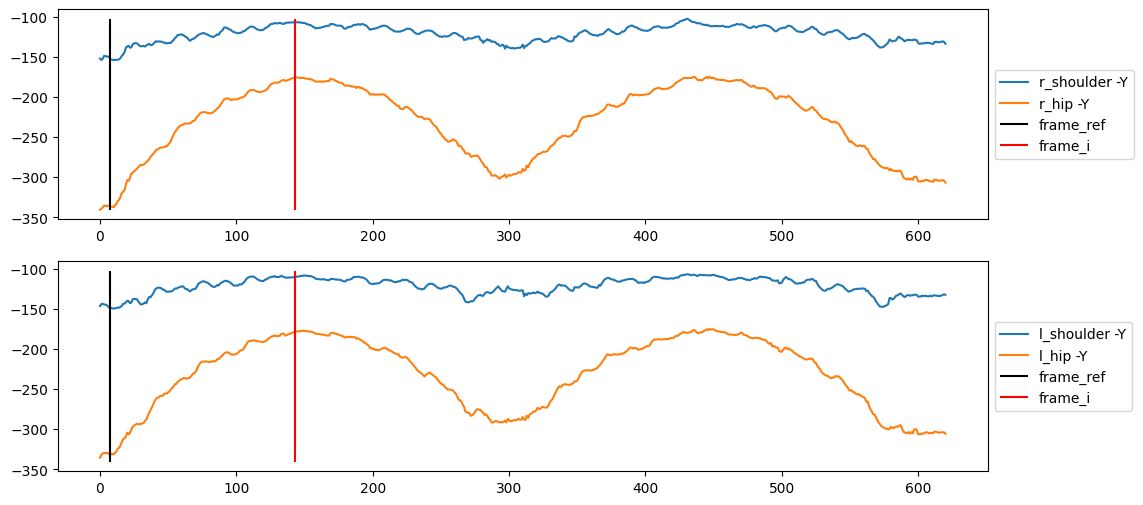

In [6]:
# calculate for one walk away from camera  
frame_ref = ground_truth_df['front_end_mat_1'].iloc[0]
frame_i =  ground_truth_df['far_end_mat_1'].iloc[0]

[right_s_ratio, left_s_ratio] = calculate_torso_height_ratio_btwn_frames(yolo_raw_df, frame_ref, frame_i)
print(right_s_ratio)
print(left_s_ratio)

# use right_s_ratio for now, seems very similar 

In [11]:
# idea 1 - using stenum formula  

# delta_d = (d_ref/s_ratio) - d_ref 

# reference distance from tall camera 
d_ref_1 = cam_1_dist

delta_d_calculated = (d_ref_1/right_s_ratio) - d_ref_1
error_1 = mat_length - delta_d_calculated
print(error_1)


0.552266962448817


In [12]:
# idea 2 - know distance traveled -> use ratio at front and back of mat (17 ft) to make ratio -> get distance from camera at front end of mat 

# delta_d = (d_ref/s_ratio) - d_ref -> solve for d_ref -> d_ref = (-s_ratio * delta_d) / (s_ratio - 1)
delta_d = mat_length

d_ref_calculated = (-right_s_ratio * delta_d) / (right_s_ratio - 1)
error_2 = d_ref_1 - d_ref_calculated
print(error_2)

-0.3272307727715149


In [9]:
# idea 3 
# Start and turn from pose estimation z distance -> 
    # assume distance traveled during linear walking is 17 ft -> velocity = (time between walk start and walk stop / 17 ft)

# for gait_vertical_r

In [10]:
# for all methods - save.csv with results from three ideas 
    # true vs calculated value (d_ref vs calculated_d_ref, etc)
        # error in feet of calculated value 
    # velocity if possible
        # error in velocity from zeno vs calculated..?




In [ ]:
# other ideas 
# double check formula 
# torso area? not sure how much width affects 
# filter 